In [1]:
from PIL import Image
import sys
import os
import pandas as pd
import matplotlib
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import re
from datetime import datetime
import random

In [2]:
debug = True
l = 100
w = 100

In [3]:
def imgDim(filename):
    img = Image.open(filename)
    #img.show()
    return img.size

def listFiles():
    lst = []
    width = []
    length = []
    for dirpath, dirnames, filenames in os.walk("Images"):
        for file in filenames:
            filepath = os.path.join(dirpath, file)
            lst.append(filepath)
            width.append(imgDim(filepath)[0])
            length.append(imgDim(filepath)[1])
    return (lst, width, length)

def avgFileDim(jpgs):
    avg_width = 0
    avg_height = 0
    for jpg in jpgs:
        avg_width = avg_width + imgDim(jpg)[0]
        avg_height = avg_height + imgDim(jpg)[1]
    avg_width = avg_width/len(jpgs)
    avg_height = avg_height/len(jpgs)
    return (avg_width, avg_height)

def imgResize(filename, length, width):
    img = Image.open(filename)
    dim = img.size
    if debug:
        print("Image ", filename, " Original size: ", dim)
        img.show()
    if dim[0] > width:
        length_resize = int(dim[1]/(dim[0]/width))
        img = img.resize((width, length_resize))
        if debug:
            print("Size after 1st resize: ", img.size)
        dim = img.size
        if dim[1] > length:
            width_resize = int(dim[0]/(dim[1]/length))
            img = img.resize((width_resize, length))
            if debug:
                print("Size after 2nd resize: ", img.size)
    elif dim[1] > length:
        width_resize = int(dim[0]/(dim[1]/length))
        img = img.resize((width_resize, length))
    if debug:
        print("Size after resize: ", img.size)
        img.show()
    return img

def NN_img_resize(filename, length, width):
    img = imgResize(filename, length, width)
    (img_width, img_length) = img.size
    np_img = np.asarray(img)
    # https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7
    # Make the color channel dimension first instead of last
    if debug:
        print("Shape before transpose ", np_img.shape)
    np_img = np_img.transpose((2, 0, 1))
    if debug:
        print("Shape after transpose ", np_img.shape)
        # Image.fromarray(np_img)
        # print(np_img.dtype)
        # print(np_img)
    #np_img.resize((375, 500, 3))
    fin_img = np.zeros((3, width, length), dtype = np.uint8)
    if debug: print(fin_img.shape)
    fin_img[:3,:img_length,:img_width] = np_img
    if debug: print(fin_img.shape)
    if debug:
        print("Final shape: ", fin_img.shape)
    return fin_img

def file_to_breed(filename):
    pattern = re.search("n[0-9]+-(.+)", filename)
    breed = pattern.group(1)
    return breed

def accuracy(prediction, answer):
    pred = prediction.argmax(1)
    accuracy = pred == answer
    accuracy = accuracy.float().mean()
    return accuracy

print(file_to_breed("n93406157384-Walker_hound"))

Walker_hound


In [4]:
# import torchvision
#ds = torchvision.datasets.ImageFolder("Images")
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
# ds = pil_loader("Images/n02086646-Blenheim_spaniel/n02086646_1077.jpg")
# type(ds)

In [5]:
debug = True
ii = "Images/n02112137-chow/n02112137_2947.jpg"
#ii = "Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg"
ii = "Images/n02086646-Blenheim_spaniel/n02086646_1077.jpg"
NN_img_resize(ii, l, w)
debug = False

Image  Images/n02086646-Blenheim_spaniel/n02086646_1077.jpg  Original size:  (97, 134)
Size after resize:  (72, 100)
Shape before transpose  (100, 72, 3)
Shape after transpose  (3, 100, 72)
(3, 100, 100)
(3, 100, 100)
Final shape:  (3, 100, 100)


In [6]:
def split_train_test_val(dirname, train_percent, test_percent):
    trainAns = []
    trainData = []
    testAns = []
    testData = []
    valAns = []
    valData = []
    
    for dirpath, dirnames, filenames in os.walk(dirname):
        for dirn in dirnames:
            for dirpath, dirnames, filenames in os.walk("Images/" + str(dirn)):
                filenames = [dirpath + "/" + e for e in filenames]
                try:
                    filenames.remove("Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg")
                except:
                    pass
                train_num = int((len(filenames) * (train_percent/100)) + 0.5)
                test_val_num = int((len(filenames) * (test_percent/100)) + 0.5)
                dirn = dirn[dirn.find("-")+1:]
                trainAns.append(str(dirn))
                trainData.append(filenames[0:train_num])
                testAns.append(str(dirn))
                testData.append(filenames[train_num:(train_num + test_val_num)])
                valAns.append(str(dirn))
                valData.append(filenames[(train_num + test_val_num):])
    return trainAns, trainData, testAns, testData, valAns, valData

In [7]:
def resize_images(filenames):
    trainData_list = []
    for i in range(0, len(filenames)-1):
        trainData_list.append([])
        for j in range(0, len(filenames[i])-1):
            trainData_list[i].append(NN_img_resize(filenames[i][j], l, w))
    return trainData_list

def resize_n_split_train_test_val():
    trainAns_filename, trainData_filename, testAns_filename, testData_filename, valAns_filename, valData_filename = split_train_test_val("Images", 80, 10)

    # need to make trainData a torch tensor
    trainData_list = resize_images(trainData_filename)
    testData_list = resize_images(testData_filename)
    valData_list = resize_images(valData_filename)

    print(trainAns_filename)
    return trainData_list, testData_list, valData_list

In [8]:
def data2xy(data):
    x = []
    y = []
    for i, images in enumerate(data):
        for j in images:
            x.append(j)
            y.append(i)
    return x,y

In [9]:
breed2num = {}
num2breed = {}

i = 0
for dirpath, dirnames, filenames in os.walk("Images"):
    for dirname in dirnames:
        breed = file_to_breed(dirname)
        breed2num[breed] = i
        num2breed[i] = breed

        i = i + 1

# print(breed2num)
# print(num2breed)

In [10]:
# Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg
def filenames2xy(filenames):
    x = []
    y = []
    for file in filenames:
        # print(file)
        y.append(breed2num[re.search("n\d+-([\w\-]+)", file).group(1)])
        x.append(NN_img_resize(file, l, w))
    return x,y

In [11]:
trainAns_filename, trainData_filename, testAns_filename, testData_filename, valAns_filename, valData_filename = split_train_test_val("Images", 80, 10)

In [12]:
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [13]:
trainData_filename = flatten(trainData_filename)
random.shuffle(trainData_filename)

testData_filename = flatten(testData_filename)
random.shuffle(testData_filename)

valData_filename = flatten(valData_filename)
random.shuffle(valData_filename)

In [14]:
# more complex network
class deepDogs(nn.Module):
    def __init__(self, dp):
        super().__init__()
        self.dp = dp
        # l by w
        self.l1 = nn.Conv2d(3, 400, 3, 1, 1)
        self.l2 = nn.AvgPool2d(2, 2)
        self.l2_drop = nn.Dropout2d(self.dp)
        # l/2 by w/2
        self.l3 = nn.Conv2d(400, 300, 3, 1, 1)
        self.l4 = nn.AvgPool2d(2, 2)
        self.l4_drop = nn.Dropout2d(self.dp)
        # l/4 by w/4
        self.l5 = nn.Conv2d(300, 200, 3, 1, 1)
        # self.l6 = nn.AvgPool2d(1, 1)
        # l/4 by w/4
        self.l7 = nn.Conv2d(200, 50, 3, 1, 1)
        self.l7_drop = nn.Dropout2d(self.dp)
        # self.l8 = nn.AvgPool2d(1, 1)
        # l/4 by w/4
        # self.l9 = nn.Linear((l//4)*(w//4)*50, (l//4)*(w//4)*50)
        self.l10 = nn.Linear((l//4)*(w//4)*50, (l//4)*(w//4)*20)
        # 1 by l*w*40
        self.lF = nn.Linear((l//4)*(w//4)*20, 120)
        # 1 by l*w*20
        
    def forward(self, d):
        d = self.l1(d)
        d = F.relu(d)
        d = self.l2_drop(self.l2(d))
        d = F.relu(d)
        d = self.l3(d)
        d = F.relu(d)
        d = self.l4_drop(self.l4(d))
        d = F.relu(d)
        d = self.l5(d)
        d = F.relu(d)
        # d = self.l6(d)
        d = F.relu(d)
        d = self.l7_drop(self.l7(d))
        d = F.relu(d)
        # d = self.l8(d)
        d = F.relu(d)
        d = d.view(-1, (l//4)*(w//4)*50)
        # d = self.l9(d)
        # d = d.view(-1, (l//4)*(w//4)*50)
        d = self.l10(d)
        # d = d.view(-1, (l//4)*(w//4)*50)
        d = self.lF(d)
        return d

In [16]:
lr = 0.01
epochs = 50
bs = 80
n = len(trainData_filename)

# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")
dev = torch.device("cuda")

In [17]:
len(trainData_filename),len(testData_filename),len(valData_filename)

(16468, 2063, 2048)

In [18]:
print (datetime.now())
x_train,y_train = filenames2xy(trainData_filename)
x_test,y_test = filenames2xy(testData_filename)
x_val,y_val = filenames2xy(valData_filename)
print (datetime.now())

2020-04-04 18:56:59.720151
2020-04-04 18:57:38.009825


In [19]:
print (datetime.now())
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_val = torch.tensor(y_val)

x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
x_val = torch.tensor(x_val, dtype=torch.float)
print (datetime.now())

2020-04-04 18:57:38.014261
2020-04-04 18:58:25.835318


In [20]:
torch.cuda.memory_allocated()

0

In [21]:
print (datetime.now())
model_dev = deepDogs(0.5).to(dev)
loss_func = F.cross_entropy

x = np.linspace(0, epochs + 1, epochs + 1)
train_y_dev = torch.zeros(epochs + 1, device=dev)
test_y_dev = torch.zeros(epochs + 1, device=dev)
val_y_dev = torch.zeros(epochs + 1, device=dev)
print (datetime.now())

2020-04-04 18:58:26.005554
2020-04-04 18:58:28.799995


In [22]:
torch.cuda.memory_allocated()

1575441920

In [23]:
def accuracy_bs(x, y):
    n = len(x)
    pred = torch.zeros((n, 120), dtype=torch.float)
    for i in range(int((n - 1)/bs) + 1):
        start = bs * i
        end = bs * (i + 1)
        x_dev = x[start:end].float().div(255).to(dev)
        output = model_dev(x_dev).to(cpu).detach()
        pred[start:end] = output
    return accuracy(pred, y)

In [24]:
def if_nan(tensor,  name):
    has_nan = (tensor != tensor)
    if has_nan.any():
        print("nan in ", name)
        print(tensor)
        print(has_nan.argmax(dim=1))
        return True
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print("nan or inf in ", name)
        return True
    return False

In [25]:
def print_parameters():
    total = 0
    print("Model's state_dict:")
    for param_name in model_dev.state_dict():
        p = model_dev.state_dict()[param_name]
        print(param_name, p.size(), p.element_size(), p.nelement());
        total += p.element_size() * p.nelement()
    print("Total size is ", total/(2**30))

In [26]:
def fit():
    train_y_dev[0] = accuracy_bs(x_train, y_train)
    test_y_dev[0] = accuracy_bs(x_test, y_test)
    val_y_dev[0] = accuracy_bs(x_val, y_val)
    
    for e in range(epochs):
        model_dev.train()
        print(datetime.now(), "epoch", e)
        # the data order is random
        random.shuffle(trainData_filename)
        for i in range(int((n - 1)/bs) + 1):
            start = bs * i
            end = bs * (i + 1)
            x_train_bs,y_train_bs = filenames2xy(trainData_filename[start:end])
            x_train_bs = torch.tensor(x_train_bs).float().div(255).to(dev)
            y_train_bs = torch.tensor(y_train_bs).to(dev)
            if_nan(x_train_bs, "x_train")
            pred = model_dev(x_train_bs)
            if if_nan(pred, "pred"): print_parameters(); print(trainData_filename[start:end])
            loss = loss_func(pred, y_train_bs)
            if_nan(loss, "loss")
            loss.backward()
        
            with torch.no_grad():
                for p in model_dev.parameters():
                    p -= p.grad * lr
                    if_nan(p, "p")
                model_dev.zero_grad()
        model_dev.eval()
        with torch.no_grad():
            acc_train = accuracy_bs(x_train, y_train)
            acc_test = accuracy_bs(x_test, y_test)
            acc_val = accuracy_bs(x_val, y_val)
            train_y_dev[e + 1] = acc_train
            test_y_dev[e + 1] = acc_test
            val_y_dev[e + 1] = acc_val
            print("Epoch {} acc_train {} acc_test {} acc_val {}".format(e, acc_train, acc_test, acc_val))
    
    model_dev.eval()
    
    plt.plot(x, train_y_dev.cpu().numpy(), label='train')
    plt.plot(x, test_y_dev.cpu().numpy(), label='test')
    plt.plot(x, val_y_dev.cpu().numpy(), label='val')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("Accuracy Plot")
    plt.legend()
    plt.show()

2020-04-04 18:58:51.909367 epoch 0
Epoch 0 acc_train 0.011416079476475716 acc_test 0.012118274345993996 acc_val 0.01123046875
2020-04-04 19:01:24.388498 epoch 1
Epoch 1 acc_train 0.014573718421161175 acc_test 0.014541929587721825 acc_val 0.01611328125
2020-04-04 19:03:56.872887 epoch 2
Epoch 2 acc_train 0.030119018629193306 acc_test 0.029568590223789215 acc_val 0.0205078125
2020-04-04 19:06:29.400651 epoch 3
Epoch 3 acc_train 0.03364099934697151 acc_test 0.029568590223789215 acc_val 0.03125
2020-04-04 19:09:02.037757 epoch 4
Epoch 4 acc_train 0.03673791512846947 acc_test 0.03490063175559044 acc_val 0.02685546875
2020-04-04 19:11:34.885453 epoch 5
Epoch 5 acc_train 0.04366043210029602 acc_test 0.0382937453687191 acc_val 0.0341796875
2020-04-04 19:14:07.676674 epoch 6
Epoch 6 acc_train 0.043053194880485535 acc_test 0.036354824900627136 acc_val 0.0322265625
2020-04-04 19:16:40.278363 epoch 7
Epoch 7 acc_train 0.051736701279878616 acc_test 0.03587009385228157 acc_val 0.03662109375
2020-04-

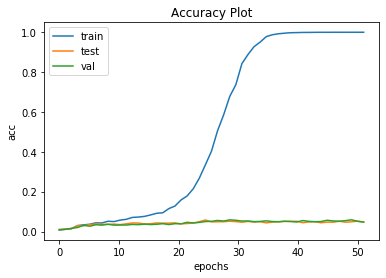

In [27]:
fit()